In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob as glob

### Loading Function

In [2]:
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy/*.npy')
    ctens=consolidate(loaddir+'codelength/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens,
            'dir': loaddir}

def takeaverage(data):

    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

def loaddataC(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy/*.npy')
    ctens=consolidate(loaddir+'codelength/*.npy') 
    ptens=consolidate(loaddir+'pleak/*.npy')
    ltens=consolidate(loaddir+'tlens/*.npy')
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            'p': ptens,
            'l': ltens,
            't': ttens,
            'dir': loaddir}

def takeaverageC(data):
    positions=data['l'].cumsum(axis=-1)
    pflat = positions.flatten()
    msk = data['m'].flatten()
    gmask=np.ones_like(data['m'])
    gmask[:,-1]=0
    gmask=gmask.astype('bool').flatten()
    validpos, inv = np.unique(pflat, return_inverse=True)
    nsamples = np.bincount(inv, weights=msk)
    e_sum = np.bincount(inv, weights=data['e'].flatten() * msk)
    eaverage = np.divide(e_sum, nsamples, out=np.zeros_like(e_sum), where=nsamples>0)
    c_sum = np.bincount(inv[gmask], weights=data['c'].flatten() * msk[gmask],minlength=nsamples.shape[0])
    caverage = np.divide(c_sum, nsamples, out=np.zeros_like(c_sum), where=nsamples>0)
    
    averages={"n": nsamples,
              'c': caverage,
              'e': eaverage,
              'vp': validpos}
    return averages

### Figure 1

In [3]:
parent='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/'
# data1=loaddata(parent+'c4/')
# avs1=takeaverage(data1)

parentC=parent
data1C=loaddataC(parentC+'c4/')
avs1C=takeaverageC(data1C)

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/c4/tok/*.npy


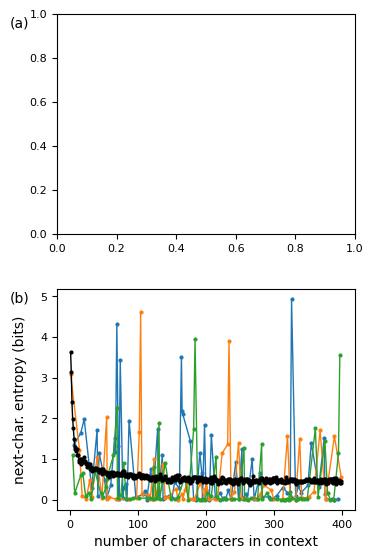

In [ ]:
figw=9.0/2.54
figh=14.0/2.54
fig1=plt.figure(figsize=(figw,figh),dpi=100)
# axfalse=fig1.add_subplot([0,0,1,1])
# axfalse.set_xticks([])
# axfalse.set_yticks([])
# axfalse.axis("off")

lbuff=0.15
rbuff=0.01
bbuff=0.08
aheight=0.4
vsep=0.1

awidth=1-lbuff-rbuff
ax1=fig1.add_subplot([lbuff,bbuff+aheight+vsep,awidth,aheight])
ax2=fig1.add_subplot([lbuff,bbuff,awidth,aheight])

fs=10
ts=8
lw=1.0
ms=2
# ax1.set_xlabel('number of tokens in context',fontsize=fs)
ax2.set_xlabel('number of characters in context', fontsize=fs)

# ax1.set_ylabel('next-token entropy (bits)', fontsize=fs)
ax2.set_ylabel('next-char. entropy (bits)', fontsize=fs)

# xvals1=np.arange(len(avs1['e']))+1

nexamples=3
nplot=100
# for i in np.arange(nexamples):
#     msk=data1['m'][i,:].astype(bool)
#     ax1.plot(xvals1[msk][:nplot],data1['e'][i,msk][:nplot],marker='o',ms=ms,lw=lw)

# ax1.plot(xvals1[:nplot],avs1['e'][:nplot],marker='o',ms=ms,lw=lw, c='k')


nplot=400
for i in np.arange(nexamples):
    msk=data1C['m'][i,:].astype(bool)
    positions=data1C['l'][i,:].cumsum()
    posmask=positions<nplot
    msk*=posmask
    ax2.plot(positions[msk],data1C['e'][i,msk],marker='o',ms=ms,lw=lw)

msk=avs1C['n']>200
posmask=avs1C['vp']<nplot
msk*=posmask
ax2.plot(avs1C['vp'][msk],avs1C['e'][msk],marker='o',lw=lw, ms=ms,c='k')

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.yaxis.set_label_coords(-0.1,0.5)

for ax, l in zip([ax1,ax2],["(a)","(b)"]):
    ax.text(-0.125,0.99, l, va='top', ha='center', transform=ax.transAxes, fontsize=fs)



In [145]:
#fig1.savefig('Figure1.pdf',bbox_inches='tight',transparent=True)
fig1.savefig('Figure1.png',bbox_inches='tight',transparent=True, dpi=300)

### Figure 2

In [3]:
llamakeys=["SimpleLlama","WikiLlama", "BBCLlama", 'C4Llama','BooksumSummaryLlama','BooksumAnalysisLlama', "BooksumChapterLlama", "GPCLlama", "PoetryFoundationLlama"]
olmokeys = ["simple", "wiki", "BBC", 'c4','BooksumText','BooksumAnalysis', "BookChapter", "gpc", "poetry"]
osskeys = ["simple", "wiki", "BBC", 'c4','BooksumText','BooksumAnalysis', "BookChapter", "gpc", "poetry"]

In [4]:
ossdata={}
ossload={}

In [5]:
parentoss='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/'
parentolmo='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/'

In [6]:
olmodata={}
olmoload={}

In [11]:
for name in olmokeys:
    if name not in olmodata.keys():
        olmoload[name]=loaddataC(parentolmo+name+"/")
        olmodata[name]=takeaverageC(olmoload[name])

for name in osskeys:
    if name not in ossdata.keys():
        ossload[name]=loaddataC(parentoss+name+"/")
        ossdata[name]=takeaverageC(ossload[name])


Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/wiki/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/entropy/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/codelength/*.npy
Loading 2000 files from /scratch/gpfs/WBIA

In [12]:
olmodata

{'simple': {'n': array([543., 545., 518., ...,   1.,   1.,   1.], shape=(10673,)),
  'c': array([2.8761742 , 2.25577511, 1.94955942, ..., 0.04954004, 0.32415363,
         0.        ], shape=(10673,)),
  'e': array([3.57919214, 2.97931747, 2.43182156, ..., 0.24233995, 0.84594703,
         0.08688818], shape=(10673,)),
  'vp': array([    1,     2,     3, ..., 11164, 11172, 11182], shape=(10673,))},
 'BBC': {'n': array([515., 478., 500., ...,   1.,   1.,   1.], shape=(10270,)),
  'c': array([2.95972418e+00, 2.61245762e+00, 2.07520682e+00, ...,
         2.78896827e-04, 1.03192090e-03, 0.00000000e+00], shape=(10270,)),
  'e': array([3.79073203e+00, 3.28705768e+00, 2.52577666e+00, ...,
         3.74934124e-03, 1.21177230e-02, 5.27567983e-01], shape=(10270,)),
  'vp': array([    1,     2,     3, ..., 10469, 10473, 10477], shape=(10270,))},
 'c4': {'n': array([529., 491., 482., ...,   1.,   1.,   1.], shape=(12296,)),
  'c': array([3.00412072, 2.58010341, 1.87492949, ..., 0.042541  , 0.0205279

/tmp/ipykernel_3051752/1995947756.py:115: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0.0,2.0e4])


Text(0.28, 0.01, 'number of characters')

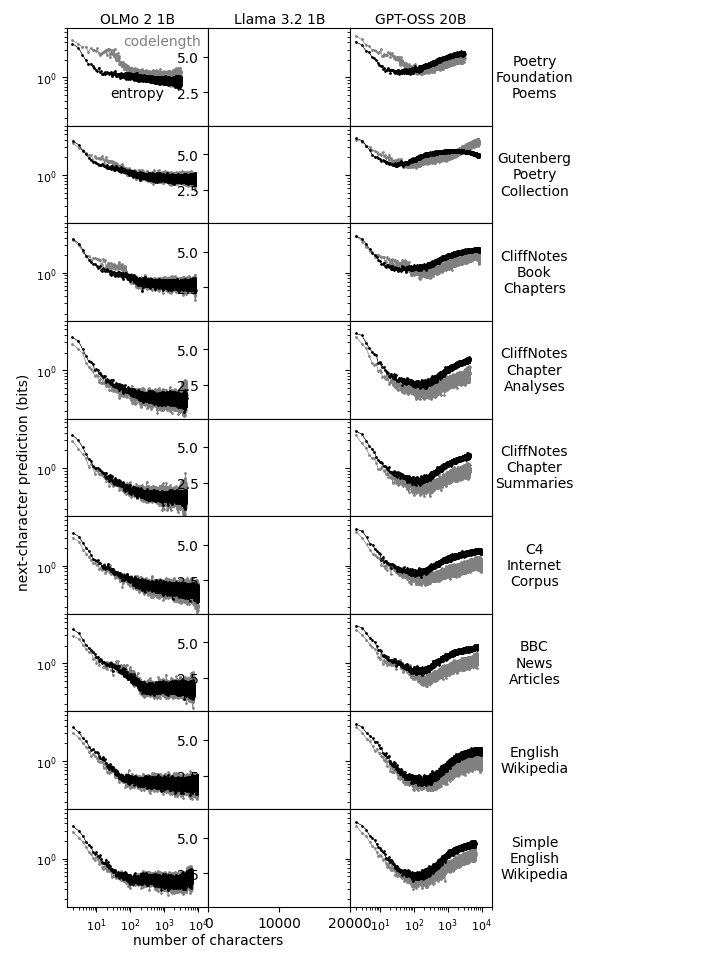

In [13]:
descriptions={
"simple" : "Simple\nEnglish\nWikipedia",
"SimpleLlama" : "Simple\nEnglish\nWikipedia",
"SimpleGPT" : "Simple\nEnglish\nWikipedia",
"wiki" : "English\nWikipedia",
"WikiLlama" : "English\nWikipedia",
"WikiGPT" : "English\nWikipedia",
"BBC" : "BBC\nNews\nArticles",
"BBCLlama": "BBC\nNews\nArticles",
"BBCGPT": "BBC\nNews\nArticles",
"c4": "C4\nInternet\nCorpus",
"C4Llama": "C4\nInternet\nCorpus",
"C4GPT": "C4\nInternet\nCorpus",
"BooksumText": "CliffNotes\nChapter\nSummaries",
"BooksumSummaryLlama": "CliffNotes\nChapter\nSummaries",
"BooksumSummaryGPT": "CliffNotes\nChapter\nSummaries",
"BooksumAnalysis": "CliffNotes\nChapter\nAnalyses",
"BooksumAnalysisLlama": "CliffNotes\nChapter\nAnalyses",
"BooksumAnalysisGPT": "CliffNotes\nChapter\nAnalyses",
"BookChapter": "CliffNotes\nBook\nChapters",
"BooksumChapterLlama": "CliffNotes\nBook\nChapters",
"BooksumChapterGPT": "CliffNotes\nBook\nChapters",
"gpc": "Gutenberg\nPoetry\nCollection",
"GPCLlama": "Gutenberg\nPoetry\nCollection",
"GPCGPT": "Gutenberg\nPoetry\nCollection",
"poetry": "Poetry\nFoundation\nPoems",
"PoetryFoundationLlama": "Poetry\nFoundation\nPoems"
,"PoetryFoundationGPT": "Poetry\nFoundation\nPoems"
}


figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(olmokeys)
ncols=3

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],olmokeys[::-1]):
    v=olmodata[k]
    
    msk=v['n']>200
    ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

# for ax, k in zip(axes[:,1],llamakeys[::-1]):
#     v=llamadata[k]

#     msk=v['n']>200
#     ax.plot(v['vp'][msk][1:]+1,v['e'][msk][1:],marker='o',ms=ms,lw=lw,label='entropy', c='k')
#     ax.plot(v['vp'][msk][1:]+1,v['c'][msk][1:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    # ax.set_xscale('log')
    # ax.set_yscale('log')

    # ax.tick_params(axis='both', which='major', labelsize=ts)
    # ax.tick_params(axis='both', which='minor', labelsize=ts)
    # ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    # ax.set_yticklabels([])

for ax, k in zip(axes[:, 2], osskeys[::-1]):
    v = ossdata[k]
    
    msk=v['n']>200
    ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    ax.set_yticklabels([])
    

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    ax.set_xlim([0.0,2.0e4])
    ax.set_ylim([0.15,7.0])


axes[0,0].text(0.5,1.02,"OLMo 2 1B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"Llama 3.2 1B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)
axes[0,2].text(0.5,1.02,"GPT-OSS 20B",va='bottom',ha='center',transform=axes[0,2].transAxes, fontsize=fs)

axes[0,0].text(0.5,0.4, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.94, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-character prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of characters', ha='center', va='baseline', fontsize=fs)

In [14]:
fig2.savefig("Figure2.pdf",transparent=True,bbox_inches='tight',dpi=300)

Paired Supplementary Figure 2 

In [119]:
olmokeysT=["Simple","Wiki", "BBC2", 'C4','BooksumSummary2','BooksumAnalysis3', "BooksumChapter3", "GPC2", "PoetryFoundation2"]
llamakeysT=["SimpleLlama","WikiLlama", "BBCLlama", 'C4Llama','BooksumSummaryLlama','BooksumAnalysisLlama', "BooksumChapterLlama", "GPCLlama", "PoetryFoundationLlama"]

In [120]:
llamadataT={}
llamaloadT={}

In [121]:
parent='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/genre_experiments/'

for name in llamakeysT:
    if name not in llamadataT.keys():
        llamaloadT[name]=loaddata(parent+name+"/")
        llamadataT[name]=takeaverage(llamaloadT[name])

In [122]:
olmodataT={}
olmoloadT={}

In [123]:
parent='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/genre_experiments/'

for name in olmokeysT:
    if name not in olmodataT.keys():
        olmoloadT[name]=loaddata(parent+name+"/")
        olmodataT[name]=takeaverage(olmoloadT[name])

/tmp/ipykernel_3497890/3202077481.py:90: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0.0,3e3])


Text(0.28, 0.01, 'number of tokens')

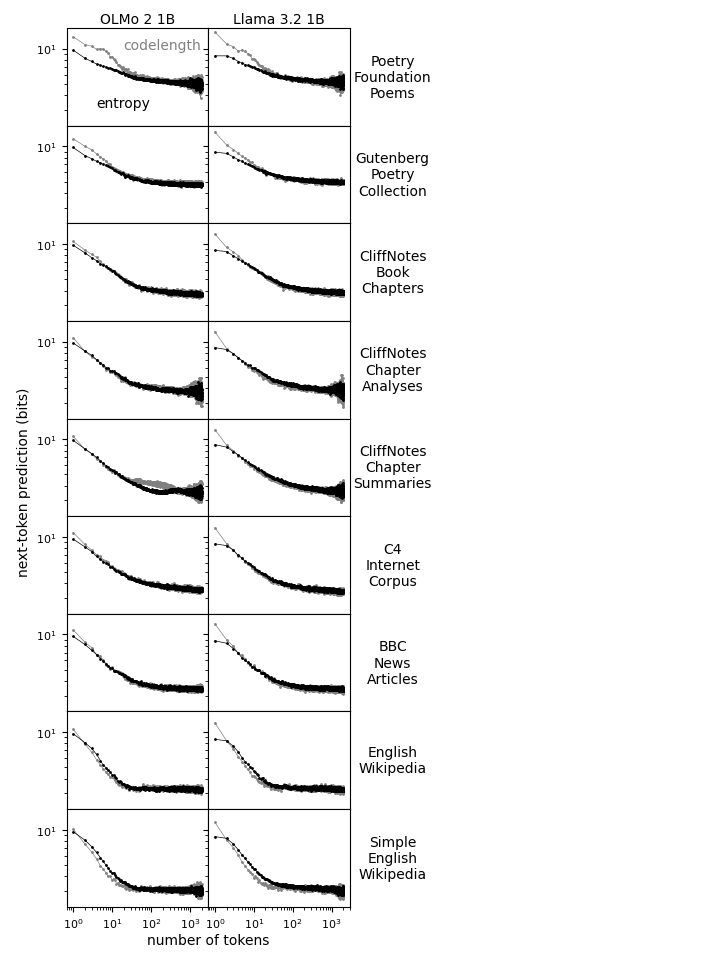

In [124]:
descriptions={
"Simple" : "Simple\nEnglish\nWikipedia",
"SimpleLlama" : "Simple\nEnglish\nWikipedia",
"Wiki" : "English\nWikipedia",
"WikiLlama" : "English\nWikipedia",
"BBC2" : "BBC\nNews\nArticles",
"BBCLlama": "BBC\nNews\nArticles",
"C4": "C4\nInternet\nCorpus",
"C4Llama": "C4\nInternet\nCorpus",
"BooksumSummary2": "CliffNotes\nChapter\nSummaries",
"BooksumSummaryLlama": "CliffNotes\nChapter\nSummaries",
"BooksumAnalysis3": "CliffNotes\nChapter\nAnalyses",
"BooksumAnalysisLlama": "CliffNotes\nChapter\nAnalyses",
"BooksumChapter3": "CliffNotes\nBook\nChapters",
"BooksumChapterLlama": "CliffNotes\nBook\nChapters",
"GPC2": "Gutenberg\nPoetry\nCollection",
"GPCLlama": "Gutenberg\nPoetry\nCollection",
"PoetryFoundation2": "Poetry\nFoundation\nPoems",
"PoetryFoundationLlama": "Poetry\nFoundation\nPoems"
}


figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(olmokeys)
ncols=2

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],olmokeysT[::-1]):
    v=olmodataT[k]

    xvals=np.arange(len(v['e']))+1
    ax.plot(xvals,v['e'],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(xvals[:-1],v['c'],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

for ax, k in zip(axes[:,1],llamakeysT[::-1]):
    v=llamadataT[k]
    xvals=np.arange(len(v['e']))
    ax.plot(xvals[1:],v['e'][1:],marker='o',ms=ms,lw=lw,label='entropy', c='k')
    ax.plot(xvals[1:-1],v['c'][1:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)

    ax.tick_params(which='major',labelleft=False)

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    ax.set_xlim([0.0,3e3])
    ax.set_ylim([2.2,15.0])
    ax.tick_params(which='minor',labelleft=False)

axes[0,0].text(0.5,1.02,"OLMo 2 1B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"Llama 3.2 1B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)

axes[0,0].text(0.4,0.3, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.9, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-token prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of tokens', ha='center', va='baseline', fontsize=fs)

In [125]:
fig2.savefig("Fig2Tokens.png",transparent=True,bbox_inches='tight',dpi=300)

### Figure 3

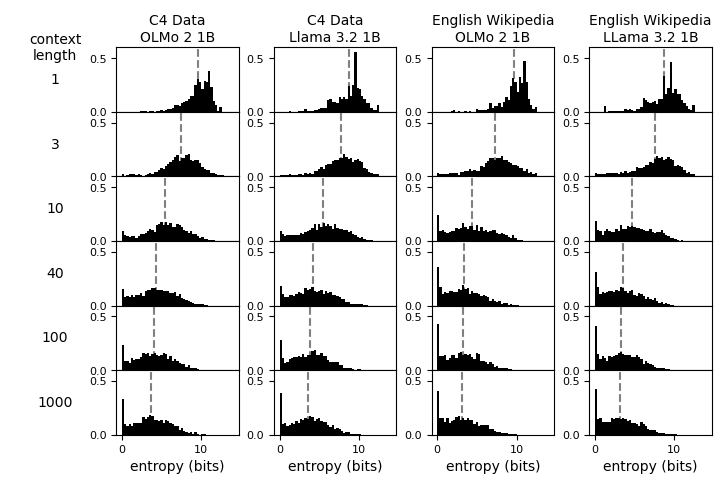

In [130]:
figw=18/2.54
figh=12/2.54

fig3=plt.figure(figsize=(figw,figh), dpi=100)
axfalse=fig3.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

steps=[0,2,9,39,99,999]
nsteps=len(steps)
ncols=4#len(viskeys)
bins=np.linspace(0,14,50)


bbuff=0.1
tbuff=0.08
#lbuff=0.07
#rbuff=0.13
lbuff=0.15
rbuff=0.01
sep=0.05
awidth=(1-rbuff-lbuff-(ncols-1)*sep)/ncols
aheight=(1-tbuff-bbuff)/nsteps

ts=8
fs=10

axes=[]
for j in np.arange(nsteps):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*(awidth+sep),1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig3.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)


for i, k in zip([0,2],['C4',"Wiki"]):
    data=olmoloadT[k]
    avs=olmodataT[k]
    for step,ax in zip(steps,axes[:,i]):       
        msk=data['m'][:,step].astype(bool)
        ax.hist(data['e'][msk,step],density=True,color='k',bins=bins);
        ax.axvline(avs['e'][step],c='gray',zorder=-1,ls='--')

for i, k in zip([1,3],['C4Llama',"WikiLlama"]):
    data=llamaloadT[k]
    avs=llamadataT[k]
    for step,ax in zip(steps,axes[:,i]):       
        msk=data['m'][:,step+1].astype(bool)
        ax.hist(data['e'][msk,step+1],density=True,color='k',bins=bins);
        ax.axvline(avs['e'][step+1],c='gray',zorder=-1,ls='--')

for ax in axes.flatten():
    ax.set_ylim([0,0.6])
    ax.set_yticks([0,0.5])
    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

for ax in axes[:-1,:].flatten():
    ax.set_xticks([])

for ax in axes[-1,:]:
    ax.set_xlabel('entropy (bits)',fontsize=fs)

#fig3.text(0.01, 0.5, 'frequency', ha='left', va='center', fontsize=fs, rotation=90)
# for step,ax in zip(steps,axes[:,-1]):
#     ax.text(1.4,0.5, f'{step+1}', ha='center',va='center',fontsize=10,transform=ax.transAxes)
# axes[0,-1].text(1.4,1.05, '# tokens\nin context', ha='center',va='bottom',fontsize=fs,transform=axes[0,-1].transAxes)

for step,ax in zip(steps,axes[:,0]):
    ax.text(-0.5,0.5, f'{step+1}', ha='center',va='center',fontsize=10,transform=ax.transAxes)

#axes[0,0].text(-0.5,1.05, '# tokens\nin context', ha='center',va='bottom',fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(-0.5,1.0, 'context\nlength', ha='center',va='center',fontsize=fs,transform=axes[0,0].transAxes)

models=["OLMo 2 1B", "Llama 3.2 1B" ,"OLMo 2 1B", "LLama 3.2 1B" ]
corpus=["C4 Data", "C4 Data", "English Wikipedia", "English Wikipedia"]

for d,m,ax in zip( corpus,models, axes[0,:]):
    text=d+"\n"+m
    ax.text(0.5, 1.05, text, ha='center', va='bottom', fontsize=fs, transform=ax.transAxes )

In [131]:
fig3.savefig("Fig3.png",transparent=True,bbox_inches='tight',dpi=300)

With Characters

In [ ]:
# steps=[1,2,3,4,5,10,100,10000]
# nsteps=len(steps)
# bins=np.linspace(0,6,30)
# fig,axes=plt.subplots(figsize=(3,2*nsteps), nrows=nsteps,ncols=1,sharex=True,sharey=True,gridspec_kw={'hspace':0})
# pp=dataC['l'].cumsum(axis=-1)

# for step,ax in zip(steps,axes):
#     pmask=(pp.flatten()==step)

#     msk=dataC['m'].flatten()[pmask].astype(bool)

#     ax.hist(dataC['e'].flatten()[pmask][msk],density=True,color='firebrick',bins=bins);
#     ax.text(1.17,0.5, f'{step}', ha='center',va='center',fontsize=10,transform=ax.transAxes)
#     ax.axvline(avsC['e'][avsC['vp']==step],c='gray',zorder=-1,ls='--')
# axes[0].text(1.17,1.00, '# characters:', ha='center',va='top',fontsize=10,transform=axes[0].transAxes)
# axes[-1].set_xlabel('Next-character entropy (bits)',fontsize=10)

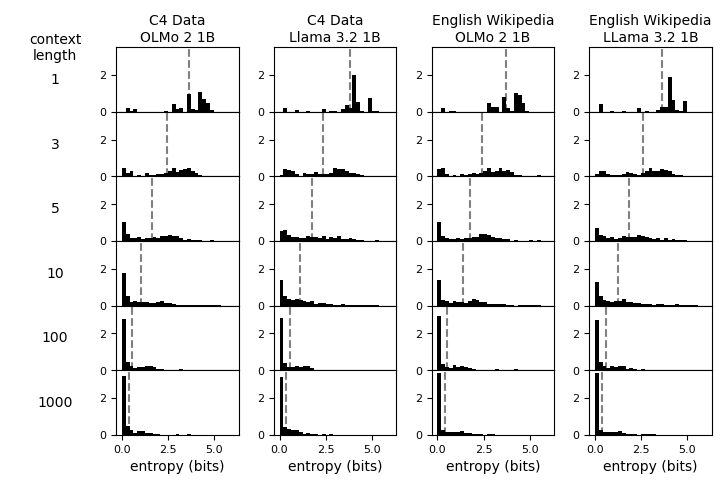

In [128]:
figw=18/2.54
figh=12/2.54

fig3=plt.figure(figsize=(figw,figh), dpi=100)
axfalse=fig3.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')


#steps=[1,2,3,4,5,10,100,10000]
steps=[1,3,5,10,100,1000]
#steps=[1,3,,39,99,999]
nsteps=len(steps)
ncols=4#len(viskeys)
#bins=np.linspace(0,14,50)
bins=np.linspace(0,6,30)


bbuff=0.1
tbuff=0.08
#lbuff=0.07
#rbuff=0.13
lbuff=0.15
rbuff=0.01
sep=0.05
awidth=(1-rbuff-lbuff-(ncols-1)*sep)/ncols
aheight=(1-tbuff-bbuff)/nsteps

ts=8
fs=10

axes=[]
for j in np.arange(nsteps):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*(awidth+sep),1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig3.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)


for i, k in zip([0,2],['C4',"Wiki"]):
    data=olmoload[k]
    avs=olmodata[k]
    pp=data['l'].cumsum(axis=-1)
    for step,ax in zip(steps,axes[:,i]):
        pmask=(pp.flatten()==step)
        msk=data['m'].flatten()[pmask].astype(bool)
        ax.hist(data['e'].flatten()[pmask][msk],density=True,color='k',bins=bins);
        ax.axvline(avs['e'][avs['vp']==step],c='gray',zorder=-1,ls='--')

for i, k in zip([1,3],['C4Llama',"WikiLlama"]):
    data=llamaload[k]
    avs=llamadata[k]
    pp=data['l'].cumsum(axis=-1)
    for step,ax in zip(steps,axes[:,i]):
        pmask=(pp.flatten()==step)
        msk=data['m'].flatten()[pmask].astype(bool)
        ax.hist(data['e'].flatten()[pmask][msk],density=True,color='k',bins=bins);
        ax.axvline(avs['e'][avs['vp']==step],c='gray',zorder=-1,ls='--')

for ax in axes.flatten():
    ax.set_ylim([0,3.5])
    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

for ax in axes[:-1,:].flatten():
    ax.set_xticks([])

for ax in axes[-1,:]:
    ax.set_xlabel('entropy (bits)',fontsize=fs)

for step,ax in zip(steps,axes[:,0]):
    ax.text(-0.5,0.5, f'{step}', ha='center',va='center',fontsize=10,transform=ax.transAxes)

axes[0,0].text(-0.5,1.0, 'context\nlength', ha='center',va='center',fontsize=fs,transform=axes[0,0].transAxes)

models=["OLMo 2 1B", "Llama 3.2 1B" ,"OLMo 2 1B", "LLama 3.2 1B" ]
corpus=["C4 Data", "C4 Data", "English Wikipedia", "English Wikipedia"]

for d,m,ax in zip( corpus,models, axes[0,:]):
    text=d+"\n"+m
    ax.text(0.5, 1.05, text, ha='center', va='bottom', fontsize=fs, transform=ax.transAxes )

In [129]:
fig3.savefig("Fig3char.png",transparent=True,bbox_inches='tight',dpi=300)

### Supplementary figure: Number of samples

Text(0, 0.5, 'Number of strings')

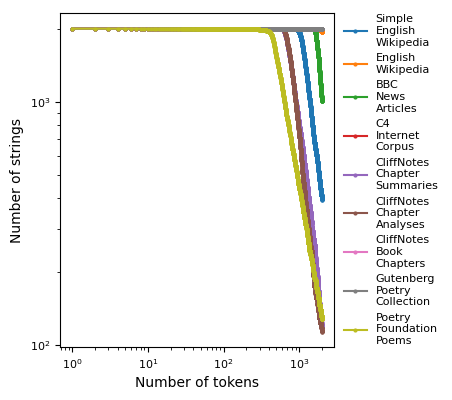

In [133]:
figw=9.0/2.54
figh=11.0/2.54

fig,ax=plt.subplots(figsize=(figw, figh),dpi=100)
fs=10
ts=8

for k in olmokeysT:
    v=olmodataT[k]
    xvs=np.arange(len(v['n']))
    ax.plot(xvs+1,v['n'],marker='o',ms=2,label=descriptions[k])

ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5),loc='center left',fontsize=ts)

ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([2,18])
ax.set_xlabel("Number of tokens",fontsize=fs)
ax.set_ylabel('Number of strings',fontsize=fs)

In [134]:
fig.savefig('Nos.png',transparent=True,bbox_inches='tight',dpi=300)

### Supplementary figure: Role of starting character

In [137]:
outsmid=takeaverage(loaddata(loaddir='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/experiments/entropy_mid/'))
outsstart=takeaverage(loaddata(loaddir='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/experiments/entropy_start/'))
outsspace=takeaverage(loaddata(loaddir='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/experiments/entropy_space/'))
outscap=takeaverage(loaddata(loaddir='/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/experiments/entropy_cap/'))

Text(0, 0.5, 'next-token entropy (bits)')

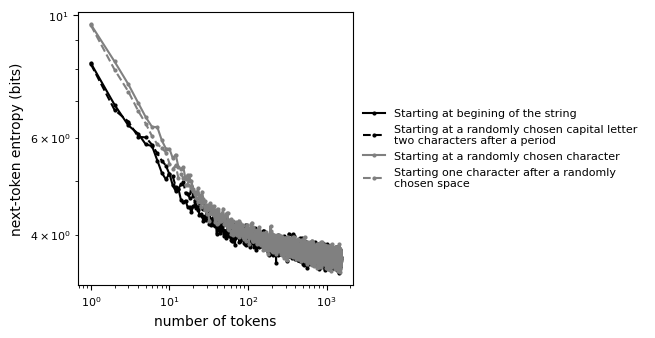

In [143]:
figw=9.0/2.54
figh=9.0/2.54

fig,ax=plt.subplots(figsize=(figw,figh),dpi=100)
ms=2
ts=8
fs=10
xvs=np.arange(len(outsstart['e']))
ax.plot(xvs+1,outsstart['e'],c='k',marker='o',ms=ms,label='Starting at begining of the string')

xvs=np.arange(len(outscap['e']))
ax.plot(xvs+1,outscap['e'],c='k',marker='o',ms=ms,label='Starting at a randomly chosen capital letter \ntwo characters after a period',ls="--")

xvs=np.arange(len(outsmid['e']))
ax.plot(xvs+1,outsmid['e'],c='gray',marker='o',ms=ms, label='Starting at a randomly chosen character')

xvs=np.arange(len(outsspace['e']))
ax.plot(xvs+1,outsspace['e'],c='gray',marker='o',ms=ms,label='Starting one character after a randomly \nchosen space',ls="--")


ax.legend(frameon=False, fontsize=ts, bbox_to_anchor=(1.0,0.5),loc='center left' )

ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("number of tokens",fontsize=fs)
ax.set_ylabel('next-token entropy (bits)',fontsize=fs)

In [144]:
fig.savefig('Startingplace.png',dpi=300,bbox_inches='tight',transparent=True)

### Old Versions

In [81]:
#Fig 1

# figw=9.0/2.54
# figh=14.0/2.54
# fig=plt.figure(figsize=(figw,figh),dpi=100)
# axfalse=fig.add_subplot([0,0,1,1])
# axfalse.set_xticks([])
# axfalse.set_yticks([])
# lbuff=0.15
# rbuff=0.01
# bbuff=0.08
# aheight=0.4
# vsep=0.1

# awidth=1-lbuff-rbuff
# ax1=fig.add_subplot([lbuff,bbuff+aheight+vsep,awidth,aheight])
# ax2=fig.add_subplot([lbuff,bbuff,awidth,aheight])

# fs=10
# ts=8
# ax1.set_xlabel('Number of tokens in context',fontsize=fs)
# ax2.set_xlabel('Number of characters in context', fontsize=fs)

# ax1.set_ylabel('Entropy of next-token (bits)', fontsize=fs)
# ax2.set_ylabel('Entropy of next-character (bits)', fontsize=fs)


# xvals1=np.arange(len(avs1['e']))+1


# nexamples=3
# for i in np.arange(nexamples):
#     msk=data1['m'][i,:].astype(bool)
#     ax1.plot(xvals1[msk],data1['e'][i,msk],marker='o',ms=4)

# ax1.plot(xvals1,avs1['e'],marker='o',ms=4, c='k')
# # ax1.set_xscale('log')
# # ax1.set_yscale('log')


# msk=avs1C['n']>200
# ax2.plot(avs1C['vp'][msk],avs1C['e'][msk],marker='o',ms=4, c='k')
# ax2.set_xscale('log')
# ax2.set_yscale('log')

# for ax in [ax1,ax2]:
#     ax.tick_params(axis='both', which='major', labelsize=ts)
#     ax.tick_params(axis='both', which='minor', labelsize=ts)




In [82]:
# descriptions={
# "Simple" : "Simple\nEnglish\nWikipedia",
# "SimpleLlama" : "Simple\nEnglish\nWikipedia",
# "Wiki" : "English\nWikipedia",
# "WikiLlama" : "English\nWikipedia",
# "BBC" : "BBC\nNews\nArticles",
# "BBCLlama": "BBC\nNews\nArticles",
# "C4": "C4\nInternet\nCorpus",
# "C4Llama": "C4\nInternet\nCorpus",
# "BooksumSummary": "CliffNotes\nChapter\nSummaries",
# "BooksumSummaryLlama": "CliffNotes\nChapter\nSummaries",
# "BooksumAnalysis": "CliffNotes\nChapter\nAnalyses",
# "BooksumAnalysisLlama": "CliffNotes\nChapter\nAnalyses",
# "BooksumChapter": "CliffNotes\nBook\nChapters",
# "BooksumChapterLlama": "CliffNotes\nBook\nChapters",
# "GPC": "Gutenberg\nPoetry\nCollection",
# "GPCLlama": "Gutenberg\nPoetry\nCollection",
# "PoetryFoundation": "Poetry\nFoundation\nPoems",
# "PoetryFoundationLlama": "Poetry\nFoundation\nPoems"
# }


# figh=28/2.54
# figw=10/2.54

# #fig2,axes=plt.subplots(figsize=(6*2,4*len(olmokeys)), ncols=2,nrows=len(olmokeys),sharex=True, sharey=True,gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
# fig2,axes=plt.subplots(figsize=(figw,figh), ncols=2,nrows=len(olmokeys),sharex=True, sharey=True,gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

# axfalse=fig2.add_subplot([0,0,1,1])
# axfalse.set_xticks([])
# axfalse.set_yticks([])
# axfalse.patch.set_visible(False)
# #axfalse.axis("off")


# fs=10
# ts=8
# lw=0.5
# ms=1



# for ax, k in zip(axes[:,0],olmokeys[::-1]):
#     v=olmodata[k]
    
#     msk=v['n']>200
#     ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
#     ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     ax.tick_params(axis='both', which='major', labelsize=ts)
#     ax.tick_params(axis='both', which='minor', labelsize=ts)

#     #ax.text(0.9,0.9,descriptions[k],va='top',ha='right',transform=ax.transAxes, fontsize=10)
    
#     #ax.set_ylabel('next-character prediction (bits)')
#     #ax.legend(frameon=False,bbox_to_anchor=(0.05,0.05),loc='lower left', fontsize=10)
#     #ax.patch.set_visible(False)


# for ax, k in zip(axes[:,1],llamakeys[::-1]):
#     v=llamadata[k]

#     msk=v['n']>200
#     ax.plot(v['vp'][msk][1:]+1,v['e'][msk][1:],marker='o',ms=ms,lw=lw,label='entropy', c='k')
#     ax.plot(v['vp'][msk][1:]+1,v['c'][msk][1:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     ax.tick_params(axis='both', which='major', labelsize=ts)
#     ax.tick_params(axis='both', which='minor', labelsize=ts)
#     #ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)



# # axes[-1,0].set_xlabel('number of characters',fontsize=10)
# # axes[-1,1].set_xlabel('number of characters',fontsize=10)

# axes[0,0].text(0.5,1.02,"OLMo 2 1B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
# axes[0,1].text(0.5,1.02,"Llama 3.2 1B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)

# # axes[0,0].legend(frameon=False,bbox_to_anchor=(0.0,0.0),loc='lower left', fontsize=fs)
# axes[0,0].text(0.5,0.4, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
# axes[0,0].text(0.95,0.94, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

# fig2.text(0.02, 0.5, 'average next-character prediction', ha='center', va='top', fontsize=fs, rotation=90)
# #fig2.text(0.5, 0.0, 'average next-character prediction', ha='center', va='top', fontsize=fs)
